In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from importlib import reload
from mppi import InputFiles as I, Calculators as C, Datasets as D

# Analysis of the main functionality of the package

We discuss some explicit example to describe the main features of the module

## InputFiles module :  construction of the pw input file

The Inputs module contains the PwIn class that allows us to built the input file of QuantumESPRESSO. 
The constructor of the class builds a the input object, the member of the class can be given and modified both using specific methods and/or by direct setting. 

Here we provide, as an example, the building of the input for Graphene:

In [2]:
input = I.PwIn()

In [3]:
k = 6
ecut = 80
a0 = 1.42
planeSep  = 10.0
A = [0.,0.,0.]
B = [0.,a0,0.]
a1 = [a0*np.sqrt(3),0.,0.]
a2 = [a0*np.sqrt(3)/2,a0*3./2,0.]
a3 = [0.,0.,planeSep]

input.set_pseudo_dir('../pseudos')
input.set_prefix('data')
input.system['ibrav'] = 0
input.cell_parameters =[a1,a2,a3]
input.set_atoms_type(1)
input.set_atoms_number(2)
input.set_atoms_position(pos_type='angstrom',pos_list=[['C',A],['C',B]])
input.atypes = {'C': [12.011,'C_pbe-20082014.UPF']}
input.set_convergence_thr(1e-8)
input.set_kpoints(ktype='automatic',kpoints=[k,k,1])
input.set_energy_cutoff(ecut)

print(input)

&control
          wf_collect = .true.
        restart_mode = 'from_scratch'
           verbosity = 'high'
          pseudo_dir = '../pseudos'
              prefix = 'data'
/&end
&system
               ibrav = 0
                ntyp = 1
                 nat = 2
             ecutwfc = 80
/&end
&electrons
            conv_thr = 1e-08
/&end
ATOMIC_SPECIES
   C   12.011   C_pbe-20082014.UPF
ATOMIC_POSITIONS { angstrom }
  C   0.0000000000   0.0000000000   0.0000000000
  C   0.0000000000   1.4200000000   0.0000000000
K_POINTS { automatic }
  6  6  1  0  0  0
CELL_PARAMETERS angstrom
  2.4595121467   0.0000000000   0.0000000000 
  1.2297560734   2.1300000000   0.0000000000 
  0.0000000000   0.0000000000  10.0000000000 



The input object can be written on file using the write method of PwIn

In [4]:
test_dir = 'test_dir'
if not os.path.isdir(test_dir): os.mkdir(test_dir)

In [5]:
input.write(test_dir+'/'+'input.in')

This class allows us also to create an instance of PwIn starting from an existing file

In [6]:
input2 = I.PwIn(test_dir+'/'+'input.in')
print(input2)

&control
          wf_collect = .true.
        restart_mode = 'from_scratch'
           verbosity = 'high'
          pseudo_dir = '../pseudos'
              prefix = 'data'
/&end
&system
               ibrav = 0
                ntyp = 1
                 nat = 2
             ecutwfc = 80
/&end
&electrons
            conv_thr = 1e-08
/&end
ATOMIC_SPECIES
   C   12.011   C_pbe-20082014.UPF
ATOMIC_POSITIONS { angstrom }
  C   0.0000000000   0.0000000000   0.0000000000
  C   0.0000000000   1.4200000000   0.0000000000
K_POINTS { automatic }
  6  6  1  0  0  0
CELL_PARAMETERS angstrom
  2.4595121467   0.0000000000   0.0000000000 
  1.2297560734   2.1300000000   0.0000000000 
  0.0000000000   0.0000000000  10.0000000000 



## Calculators module : a calculator object for QuantumESPRESSO

Initialize the calculator

In [7]:
code = C.QeCalculator(omp=1,mpi_run='mpirun -np 4',executable='pw.x',verbose=True,skip=False)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 4 pw.x


Specifies the input object, the name of the file and the run_dir, if post_processing is True the .run returns an instance of the pw_out method of qepppy and contains the results of the computation

In [8]:
results = code.run(input=input,name='test',run_dir='pw_run',post_processing=True)

execute : cd pw_run ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp test.in > test.log


Extract the total energy (in Hartree)

In [9]:
results.E_tot

-11.40037440619968

A lot of quantities can be extracted from results, for instance

In [10]:
results.alat #atomic units = angstrom/0.529177211

4.647804377769

In [11]:
results.atoms_coord_cart # in which units ?????

array([[0.        , 0.        , 0.        ],
       [0.        , 2.68341111, 0.        ]])

No handles with labels found to put in legend.


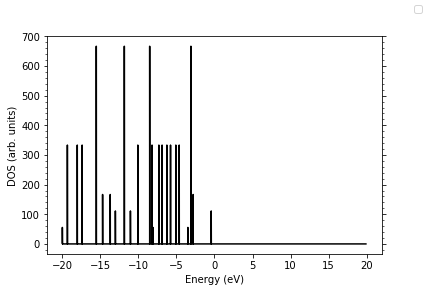

array([[-20.   ,   0.   ],
       [-19.999,   0.   ],
       [-19.998,   0.   ],
       ...,
       [ 19.998,   0.   ],
       [ 19.999,   0.   ],
       [ 20.   ,   0.   ]])

In [12]:
#pFile : option to enable/disable file save
#fname : output file name
results.density_of_states(pFile=False)

## Dataset module : how to manage several calculations

Show the functionality of this module by performin a convergence test for the ground state in function of the number of k-points and of the energy cutoff

In [13]:
code = C.QeCalculator(omp=1,mpi_run='mpirun -np 4',executable='pw.x',verbose=True,skip=False)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 4 pw.x


In [14]:
study = D.Dataset(label='convergence_test',run_dir='gs_run_dir')

In [15]:
kpoints = [3,6,9,12]
ecut = [40,60,80,100]

In [17]:
for k in kpoints:
    for e in ecut:
        idd = {'k' : k, 'ecut' : e} 
        input.set_prefix(D.name_from_id(idd))
        input.set_kpoints(ktype='automatic',kpoints=[k,k,1])
        input.set_energy_cutoff(e)
        study.append_run(id=idd,calculator=code,input=input)

The paramaters of the dataset are given as follows, for instance

In [18]:
print(study.ids)
print(study.calculators)
print(study.runs[3])

[{'k': 3, 'ecut': 40}, {'k': 3, 'ecut': 60}, {'k': 3, 'ecut': 80}, {'k': 3, 'ecut': 100}, {'k': 6, 'ecut': 40}, {'k': 6, 'ecut': 60}, {'k': 6, 'ecut': 80}, {'k': 6, 'ecut': 100}, {'k': 9, 'ecut': 40}, {'k': 9, 'ecut': 60}, {'k': 9, 'ecut': 80}, {'k': 9, 'ecut': 100}, {'k': 12, 'ecut': 40}, {'k': 12, 'ecut': 60}, {'k': 12, 'ecut': 80}, {'k': 12, 'ecut': 100}]
[{'calc': <mppi.Calculators.Calculators.QeCalculator object at 0x7fcde4d396d8>, 'runs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}]
&control
          wf_collect = .true.
        restart_mode = 'from_scratch'
           verbosity = 'high'
          pseudo_dir = '../pseudos'
              prefix = 'ecut:100,k:3'
/&end
&system
               ibrav = 0
                ntyp = 1
                 nat = 2
             ecutwfc = 100
/&end
&electrons
            conv_thr = 1e-08
/&end
ATOMIC_SPECIES
   C   12.011   C_pbe-20082014.UPF
ATOMIC_POSITIONS { angstrom }
  C   0.0000000000   0.0000000000   0.0000000000
  C   0.00000000

In [19]:
results = study.run(post_processing=True)

execute : cd gs_run_dir ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:40,k:3.in > ecut:40,k:3.log
execute : cd gs_run_dir ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:60,k:3.in > ecut:60,k:3.log
execute : cd gs_run_dir ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:80,k:3.in > ecut:80,k:3.log
execute : cd gs_run_dir ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:100,k:3.in > ecut:100,k:3.log
execute : cd gs_run_dir ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:40,k:6.in > ecut:40,k:6.log
execute : cd gs_run_dir ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:60,k:6.in > ecut:60,k:6.log
execute : cd gs_run_dir ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:80,k:6.in > ecut:80,k:6.log
execute : cd gs_run_dir ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:100,k:6.in > ecut:100,k:6.log
execute : cd gs_run_dir ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:40,k:9.in > ecut:40,k:9.log
execute : cd gs_run_dir ; OMP_NUM_THREADS=1 mpirun -np 4 pw.x -inp ecut:60,k:9.in > ecut:60,k:9.

## Dataset module : post_processing of data

All the results of the dataset are stored in study.results as a list

In [20]:
study.results

{0: <qepppy.qe.pw_out.pw_out at 0x7fcde4c75c18>,
 1: <qepppy.qe.pw_out.pw_out at 0x7fcde6dcd630>,
 2: <qepppy.qe.pw_out.pw_out at 0x7fcde4c94828>,
 3: <qepppy.qe.pw_out.pw_out at 0x7fcde4c6af28>,
 4: <qepppy.qe.pw_out.pw_out at 0x7fcde4c75f98>,
 5: <qepppy.qe.pw_out.pw_out at 0x7fcde4bf6f98>,
 6: <qepppy.qe.pw_out.pw_out at 0x7fcde4bfefd0>,
 7: <qepppy.qe.pw_out.pw_out at 0x7fcde4c75ac8>,
 8: <qepppy.qe.pw_out.pw_out at 0x7fcde4bf6cf8>,
 9: <qepppy.qe.pw_out.pw_out at 0x7fcde4c6add8>,
 10: <qepppy.qe.pw_out.pw_out at 0x7fcde4c75c88>,
 11: <qepppy.qe.pw_out.pw_out at 0x7fcde4c12550>,
 12: <qepppy.qe.pw_out.pw_out at 0x7fcde4c6a860>,
 13: <qepppy.qe.pw_out.pw_out at 0x7fcde4bfea58>,
 14: <qepppy.qe.pw_out.pw_out at 0x7fcde4cc55c0>,
 15: <qepppy.qe.pw_out.pw_out at 0x7fcde4c12780>}

And the associated parameters are written in the ids

In [21]:
study.ids

[{'k': 3, 'ecut': 40},
 {'k': 3, 'ecut': 60},
 {'k': 3, 'ecut': 80},
 {'k': 3, 'ecut': 100},
 {'k': 6, 'ecut': 40},
 {'k': 6, 'ecut': 60},
 {'k': 6, 'ecut': 80},
 {'k': 6, 'ecut': 100},
 {'k': 9, 'ecut': 40},
 {'k': 9, 'ecut': 60},
 {'k': 9, 'ecut': 80},
 {'k': 9, 'ecut': 100},
 {'k': 12, 'ecut': 40},
 {'k': 12, 'ecut': 60},
 {'k': 12, 'ecut': 80},
 {'k': 12, 'ecut': 100}]

The fetch_results method of Dataset can be used to extract a quantity, for instance the total energy E_tot,for a subset of the Dataset elements specified by a dictionary, as follows

In [22]:
data=study.fetch_results(id={'ecut': 40},attribute='E_tot')
data

[-11.35092388834179,
 -11.37186320611442,
 -11.37341431882221,
 -11.37382494507814]

It can also be used to plot the usual convergence analysis

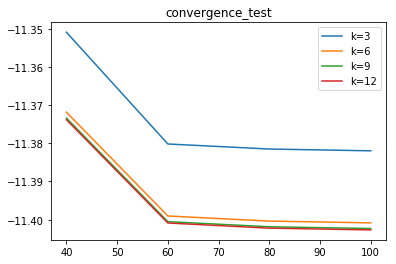

In [23]:
for k in kpoints:
    data=study.fetch_results(id={'k': k},attribute='E_tot')
    plt.plot(ecut,data,label='k='+str(k))
plt.title(study.label)
plt.legend()
plt.show()
    